In [203]:
import cairo
import numpy as np
from noise import snoise2, snoise4
from matplotlib import pyplot as plt
from PIL import Image
from enum import Enum
from scipy import ndimage
import math
import time
import copy

In [2]:
_MAXX_ = 200
_MAXY_ = 200

In [3]:
Wentworth = Enum('Wentworth', [
    'Clay', 
    'Silt_vf', 'Silt_f', 'Silt_m', 'Silt_c', 
    'Sand_vf','Sand_f','Sand_m','Sand_c','Sand_vc',
    'Granules', 'Pebbles_f', 'Pebbles_m', 'Pebbles_c', 'Pebbles_vc', 
    'Cobbles'])

In [4]:
'''Everything is hand entered and tuned, please go ahead and tune to your liking
size => particle size
edCurve => list index is low -> high stream velocity, list values is the resistance to moving vs stream velocity
'''
Hjulstrom = {
    Wentworth.Clay.name:
    {
        "size":0.001,
        "edCurve":[1.0, 1.0, 0.9999, 0.9999, 0.999, 0.999, 0.999, 0.99, 0.99, 0.9],
    },
        Wentworth.Silt_vf.name:
    {
        "size":0.004,
        "edCurve":[1.01, 1.0001, 0.9999, 0.9999, 0.99, 0.99, 0.99, 0.9, 0.9, 0.8],
    },
        Wentworth.Silt_f.name:
    {
        "size":0.008,
        "edCurve":[1.1, 1.01, 1.0, 0.9999, 0.99, 0.99, 0.99, 0.9, 0.9, 0.8],
    },
        Wentworth.Silt_m.name:
    {
        "size":0.016,
        "edCurve":[1.2, 1.02, 1.0, 1.0, 0.9999, 0.999, 0.99, 0.9, 0.9, 0.8],
    },
        Wentworth.Silt_c.name:
    {
        "size":0.031,
        "edCurve":[1.3, 1.04, 0.99999, 0.99999, 0.999, 0.999, 0.99, 0.9, 0.9, 0.8],
    },
        Wentworth.Sand_vf.name:
    {
        "size":0.062,
        "edCurve":[1.4, 1.08, 0.999999, 0.999999, 0.999, 0.999, 0.999, 0.99, 0.9, 0.8],
    },
        Wentworth.Sand_f.name:
    {
        "size":0.125,
        "edCurve":[1.5, 1.09, 1.01, 1.0, 0.9999, 0.99, 0.99, 0.9, 0.8, 0.7],
    },
        Wentworth.Sand_m.name:
    {
        "size":0.250,
        "edCurve":[1.6, 1.1, 1.1, 0.999999, 0.999, 0.999, 0.999, 0.99, 0.9, 0.8],
    },
        Wentworth.Sand_c.name:
    {
        "size":0.5,
        "edCurve":[1.7, 1.2, 1.2, 1.0, 1.0, 1.0, 1.0, 0.99, 0.9, 0.8],
    },
        Wentworth.Sand_vc.name:
    {
        "size":1.0,
        "edCurve":[1.8, 1.3, 1.0, 1.0, 0.999, 0.999, 0.999, 0.99, 0.9, 0.8],
    },
        Wentworth.Sand_vc.name:
    {
        "size":1.0,
        "edCurve":[1.8, 1.3, 1.0, 1.0, 0.999, 0.999, 0.999, 0.99, 0.9, 0.8],
    },
        Wentworth.Granules.name:
    {
        "size":2.0,
        "edCurve":[1.9, 1.4, 1.1, 1.0, 0.999, 0.999, 0.999, 0.999, 0.99, 0.8],
    },
        Wentworth.Pebbles_f.name:
    {
        "size":4.0,
        "edCurve":[2.1, 1.5, 1.2, 1.1, 1.0, 1.0, 0.999, 0.99, 0.99, 0.8],
    },
        Wentworth.Pebbles_m.name:
    {
        "size":8.0,
        "edCurve":[2.2, 1.6, 1.3, 1.2, 1.0, 1.0, 1.0, 0.999, 0.99, 0.9],
    },
        Wentworth.Pebbles_c.name:
    {
        "size":16.0,
        "edCurve":[2.3, 1.7, 1.4, 1.3, 1.0, 1.0, 1.0, 0.999, 0.999, 0.99],
    },
        Wentworth.Pebbles_vc.name:
    {
        "size":32.0,
        "edCurve":[2.4, 1.8, 1.5, 1.4, 1.0, 1.0, 1.0, 0.999, 0.999, 0.99],
    },
        Wentworth.Cobbles.name:
    {
        "size":64.0,
        "edCurve":[2.5, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9999, 0.999],
    },
}

Nothing Created
Grain must be an Enum of type Wentworth, Nothing Created
Sediment value gotten:  0.901575118303299


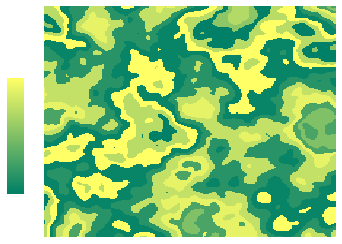

In [258]:
class Sediment():    

    grainType = None
    activeLayer = None
    
    def __init__(self, grain = None):
        if grain != None:
            if type(grain) != Wentworth:
                #invalid instatiation
                print("Grain must be an Enum of type Wentworth, Nothing Created")
                del(self)            
                return None
        else:            
            #invalid instatiation
            print("Nothing Created")
            del(self)
            return None
        
        #valid instatiation
        self.grainType = grain
        
        self.initActiveLayer()
        
    def initActiveLayer(self):
        self.activeLayer = np.zeros((_MAXX_, _MAXY_))
        
        for y in range(_MAXY_):
            for x in range(_MAXY_):
                self.activeLayer[x, y] = self.getSediment(x, y)
    
    def displayDistribution(self):
        plt.subplot()
        plt.axis('off')
        plt.pcolormesh(self.activeLayer, cmap='summer')
        
        plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        cax = plt.axes((0.04, 0.25, 0.04, 0.4))
        plt.axis('off')
        plt.colorbar(cax=cax)
        
    def getSediment(self, x, y, z = 0):
        ##sediment placement is a smooth noise function
        no = snoise4(x / 100.0, y / 100.0, 100.0 * self.grainType.value, z / 100.0, 4)

        ## add some stepping
        amountOfStepping = 10.0
        no = np.floor(no * amountOfStepping) / amountOfStepping 
        
        #scramble densities
        no = (snoise2(no * 123.0, 456.0 * self.grainType.value) + 1.0) / 2.0
        
        return no

    def getActiveLayer(self, x, y):
        return self.activeLayer[x, y]
    
    def setActiveLayer(self, x, y, value):
        self.activeLayer[x, y] = value
        
sediment_a = Sediment()
##Nothing Created

sediment_b = Sediment('Clay')
##Grain must be an Enum of type Wentworth, Nothing Created

clay = Wentworth.Clay

sediment_c = Sediment(clay)
print("Sediment value gotten: ", sediment_c.getSediment(1, 2, 3))
##Sediment value gotten: |Some Value|
sediment_c.displayDistribution()

In [259]:
#initialize sediment layers
land = {}

for s in Wentworth:
    newSediment = Sediment(s)
    land[s.name] = newSediment
    

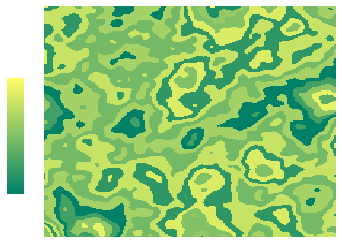

In [260]:
land[Wentworth.Granules.name].displayDistribution()

In [261]:
class Water():
    waterLayer = np.random.rand(_MAXX_, _MAXY_)

    def readWater(self, x, y):
        return self.activeSedimentLayer[x, y]
    
    def addWater(self, x, y, value):
        self.activeSedimentLayer[x, y] += value
        
    def displayDistribution(self):
        plt.subplot()
        plt.axis('off')
        plt.pcolormesh(self.waterLayer, cmap='cool')
        
        plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        cax = plt.axes((0.04, 0.25, 0.04, 0.4))
        plt.axis('off')
        plt.colorbar(cax=cax)

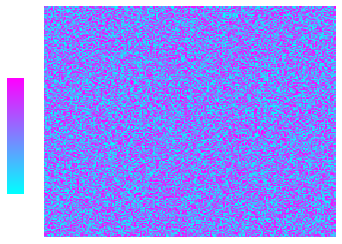

In [262]:
water = Water()

water.displayDistribution()

In [263]:
class Terrain():
    heightMap = None
    
    def __init__(self):
        self.heightMap = np.zeros((_MAXX_, _MAXY_))

        for y in range(_MAXY_):
            for x in range(_MAXX_):
                
                offsetx = snoise2(x / 10.0, y / 10.0 + 1000.0) * 1.0
                offsety = snoise2(x / 100.0, y / 100.0 + 1000.0) * 100.0
                self.heightMap[x, y] = ((snoise2(x / (200.0 + offsetx), y / (200.0 + offsety), 4) + 1.0) / 2.0) ** 0.5

    def displayContour(self, contourFreq, threshold = 0.99):
        
        contourMap = copy.copy(self.heightMap)
        
        contourMap = np.where(np.sin(contourMap * contourFreq) > threshold, 1, 0)
        

        
        plt.subplot()
        plt.axis('off')
        plt.pcolormesh(contourMap, cmap='binary')

        plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        cax = plt.axes((0.04, 0.25, 0.04, 0.4))
        plt.axis('off')
        plt.colorbar(cax=cax)

        
        
    def displayHeight(self):                
        plt.subplot()
        plt.axis('off')
        plt.pcolormesh(self.heightMap, cmap='hot')
        
        plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        cax = plt.axes((0.04, 0.25, 0.04, 0.4))
        plt.axis('off')
        plt.colorbar(cax=cax)
    
    def calcAngleOfSlope(self):
        '''angle of slope map
        '''
        a, b = self.calcSlopeNormal()
        
        c = np.zeros((_MAXX_, _MAXY_, 2))
        
        c = np.arctan2(a, b)
        angleOfSlopeMap = (c + 1.0) / 2.0
        
        return angleOfSlopeMap
    
    def calcSlopeNormal(self):
        x = self.heightMap - np.roll(self.heightMap, 1, 0)
        y = self.heightMap - np.roll(self.heightMap, 1, 1)
        
        return (x,y)


In [264]:
terrain = Terrain()

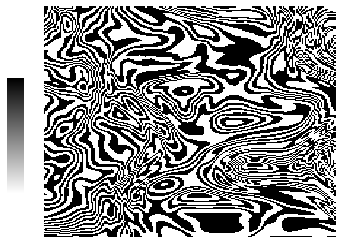

In [265]:
terrain.displayContour(240, 0.0)

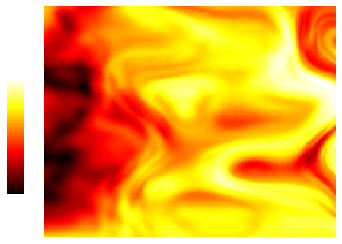

In [266]:
terrain.displayHeight()

In [267]:
t1 = time.clock_gettime_ns(time.CLOCK_REALTIME)

angleOfSlopeMap = terrain.calcAngleOfSlope()

t2 = time.clock_gettime_ns(time.CLOCK_REALTIME)

print(str((t2 - t1) / 1000000000.0) + " s")

0.001551599 s


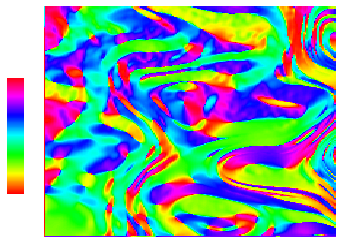

In [269]:
plt.subplot()
plt.axis('off')
plt.pcolormesh(angleOfSlopeMap, cmap='hsv')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes((0.04, 0.25, 0.04, 0.4))
plt.axis('off')
plt.colorbar(cax=cax)